# Final Project Results and Metrics

In [4]:
import random
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,f1_score
import numpy as np
import ast
#import the models
import baseline
import nn_with_rules
import base_nn



random.seed(0) # set a seed for reproducibility

### Run Models or Load in from output


In [6]:
# baseline_output = "output/baseline_test.csv"
# base_nn_output = "output/base_nn_test.csv"
# nn_with_rules_output = "output/nn_with_rules_test_2.csv"

baseline_output = "output/470-results/baseline_augment2_files_470.csv"
base_nn_output = "output/470-results/base_nn.csv"
nn_with_rules_output = "output/470-results/nn_with_rules_weights.csv"

num_iters = 20 # number of times to run the baseline model if not loading it in

#get baseline (just rules based results)
if os.path.exists(baseline_output):
    baseline_df = pd.read_csv(baseline_output)
else:
    baseline_df= baseline.run_baseline(num_iters)
#get base_nn results
if os.path.exists(base_nn_output):
    base_nn_df = pd.read_csv(base_nn_output)
else:
    base_nn_df = base_nn.run_base_nn()
#get nn_with_rules results
if os.path.exists(nn_with_rules_output):
    nn_with_rules_df = pd.read_csv(nn_with_rules_output)
else:
    nn_with_rules_df = nn_with_rules.run_nn_with_rules()

baseline_df['y_pred'] = baseline_df['y_pred'].apply(ast.literal_eval)#this is a list of the output over x num of runs so treat it like a list
 

### Make sure that the results dfs are comparable

In [26]:
print(baseline_df.shape) # TODO: figure out why they aren't the same size, doing a different preprocessing approach for this
print(base_nn_df.shape)
print(nn_with_rules_df.shape)

print(baseline_df.columns)

(447, 27)
(447, 27)
(447, 27)
Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'index', 'ID', 'FIle',
       'sent_i', 'sent', 'ne_info', 'amr_prints', 'amr_graph', 'amr_head_name',
       'amr_tail_name', 'amr_role', 'umr_head_name', 'umr_tail_name',
       'umr_role', 'amr_head_id', 'umr_head_id', 'amr_tail_id', 'umr_tail_id',
       'animacy', 'y_gold', 'counts', 'y_guess', 'y_guess_dist', 'y_pred'],
      dtype='object')


In [8]:
print("BASELINE (20x iterations)")
print(baseline_df["y_pred"][0:5])

print("BASE NN")
print(base_nn_df["y_pred"][0:5])

print("NN with RULES")
print(nn_with_rules_df["y_pred"][0:5])


BASELINE (20x iterations)
0    [:condition, :condition, :condition, :conditio...
1            [:cause, :cause, :cause, :cause, :reason]
2    [:condition, :condition, :condition, :conditio...
3            [:cause, :cause, :cause, :cause, :reason]
4    [:condition, :condition, :condition, :conditio...
Name: y_pred, dtype: object
BASE NN
0    :condition
1        :cause
2    :condition
3        :cause
4    :condition
Name: y_pred, dtype: object
NN with RULES
0    :condition
1        :cause
2    :condition
3        :cause
4    :condition
Name: y_pred, dtype: object


In [9]:
def get_macro_f1(df):
    # Extract values from DataFrame columns
    y_true = df['umr_role'].values
    y_preds_list = df['y_pred'].values

    # Calculate accuracy

    if type(y_preds_list[0]) == list:
        y_preds_transposed = list(map(list, zip(*y_preds_list)))
        
        # Compute accuracy for each set of predictions
        f1_scores = [f1_score(y_true, y_preds,average="macro") for y_preds in y_preds_transposed]
        

        # Compute average accuracy
        f1 = np.mean(f1_scores) 
    else:
        f1 = f1_score(y_true, y_preds_list,average="macro")
        #print(confusion_matrix(y_preds_list,y_true))
    return f1


total_f1 = {"baseline": get_macro_f1(baseline_df),
             "base_nn": get_macro_f1(base_nn_df),
             "nn with rules": get_macro_f1(nn_with_rules_df)}

print(total_f1)

{'baseline': 0.6688286348376229, 'base_nn': 0.31170861986326237, 'nn with rules': 0.4249330317877109}


In [11]:
def get_accuracy(df):
    # Extract values from DataFrame columns
    y_true = df['umr_role'].values
    y_preds_list = df['y_pred'].values

    # Calculate accuracy

    if type(y_preds_list[0]) == list:
        y_preds_transposed = list(map(list, zip(*y_preds_list)))
        
        # Compute accuracy for each set of predictions
        accuracies = [accuracy_score(y_true, y_preds) for y_preds in y_preds_transposed]
        

        # Compute average accuracy
        accuracy = np.mean(accuracies) 
    else:
        accuracy = accuracy_score(y_true, y_preds_list)
        print(confusion_matrix(y_preds_list,y_true))
    return accuracy

# total_acc = {"baseline": get_accuracy(baseline_df),
#              "base_nn": get_accuracy(base_nn_df),
#              "nn with rules": get_accuracy(nn_with_rules_df)}

# print(total_acc)

In [12]:
def plot_dict(data, title):
    # Extract x and y values from the dictionary
    x_values = list(data.keys())
    y_values = list(data.values())

    color_model1 = '#B186C5'  # Purple

    # Plotting
    plt.bar(x_values, y_values, color=color_model1, edgecolor='grey')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

#plot_dict(total_acc, "Total Accuracy")


In [27]:
def get_per_class_f1(df):
    y_true = df["umr_role"]
    y_pred = df["y_pred"]

    if type(y_pred[0]) == list: #baseline with 20 runs, get the average per class f1
        y_preds_transposed = list(map(list, zip(*y_pred)))
        
        f1_dicts = {}
        for i in range(len(y_preds_transposed)):
            report = classification_report(y_true, y_preds_transposed[i], output_dict = True,zero_division=0.0)
            
            class_labels = [label for label in report.keys()]
            f1_scores = []
            for label in class_labels:
                if label[0] == ":":
                    f1_scores.append(report[label]['f1-score'])
            f1_dict = dict(zip(class_labels, f1_scores))
            f1_dicts[i] = f1_dict

        #make sure they all have the same keys:
            # Find the union of all keys in the interior dictionaries
        all_keys = set().union(*f1_dicts.values())

        # Update each interior dictionary with missing keys, assigning them a value of 0
        for entry in f1_dicts.values():
            for key in all_keys:
                entry.setdefault(key, 0)
        
        averages_dict = {}
        # Iterate over the keys ('cause' and 'reason')
        for key in f1_dicts[0].keys():
            # Calculate the average for each key
            average_value = np.mean([entry[key] for entry in f1_dicts.values()])
            # Store the result in the averages_dict
            averages_dict[key] = average_value
        
        f1_dict = averages_dict
        
    else:
        report = classification_report(y_true, y_pred, output_dict = True,zero_division=0.0)
        print(classification_report(y_true, y_pred, zero_division=0.0))
        class_labels = [label for label in report.keys()]
        f1_scores = []
        for label in class_labels:
            if label[0] == ":":
                f1_scores.append(report[label]['f1-score'])
        
        f1_dict = dict(zip(class_labels, f1_scores))

    #hand remove umr-roles that are predicted but are wrong
    if ":start"  in f1_dict:
       del f1_dict[":start"]
    if ":Cause-of"  in f1_dict:
       del f1_dict[":Cause-of"]

  #  if ":Material-of" not in f1_dict:
    #    f1_dict[":Material-of"] = 0

    print(len(f1_dict.keys()), f1_dict.keys())
    return f1_dict
    

print(get_per_class_f1(base_nn_df))
print(get_per_class_f1(nn_with_rules_df))
print(get_per_class_f1(baseline_df))

    

              precision    recall  f1-score   support

   :Cause-of       0.00      0.00      0.00         0
:Material-of       0.00      0.00      0.00         0
      :cause       0.36      0.13      0.20        30
  :condition       1.00      1.00      1.00        15
       :goal       0.82      1.00      0.90        53
      :group       0.00      0.00      0.00       107
   :material       0.21      0.92      0.35        38
        :mod       0.00      0.00      0.00         1
       :part       1.00      0.64      0.78        58
     :reason       0.00      0.00      0.00        24
  :recipient       0.00      0.00      0.00        12
     :source       0.71      1.00      0.83        79
      :start       0.00      0.00      0.00        30

    accuracy                           0.50       447
   macro avg       0.32      0.36      0.31       447
weighted avg       0.43      0.50      0.43       447

11 dict_keys([':Material-of', ':cause', ':condition', ':goal', ':group', ':mate

              precision    recall  f1-score   support

   :Cause-of       0.00      0.00      0.00         0
:Material-of       0.00      0.00      0.00         0
      :cause       0.36      0.13      0.20        30
  :condition       1.00      1.00      1.00        15
       :goal       0.82      1.00      0.90        53
      :group       0.00      0.00      0.00       107
   :material       0.21      0.92      0.35        38
        :mod       0.00      0.00      0.00         1
       :part       1.00      0.64      0.78        58
     :reason       0.00      0.00      0.00        24
  :recipient       0.00      0.00      0.00        12
     :source       0.71      1.00      0.83        79
      :start       0.00      0.00      0.00        30

    accuracy                           0.50       447
   macro avg       0.32      0.36      0.31       447
weighted avg       0.43      0.50      0.43       447

11 dict_keys([':Material-of', ':cause', ':condition', ':goal', ':group', ':mate

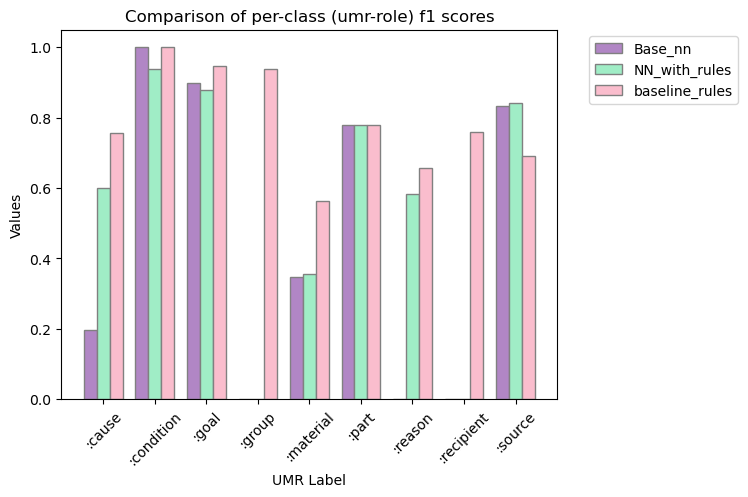

In [40]:
def plot_dicts(model1, model2, model3):


    # Extract keys and values
    del model1[":Material-of"]
    del model1[":mod"]
    del model2[":mod"]
    del model3[":mod"]
    keys = list(model1.keys())
    values_model1 = list(model1.values())
    values_model2 = list(model2.values())
    values_model3 = list(model3.values())

    
    

    

    # Set the width of the bars
    bar_width = 0.25

    # Set the positions for the bars on the x-axis
    r1 = range(len(keys))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    color_model1 = '#B186C5'  # Purple
    color_model2 = '#A0EDC6'  # Pink
    color_model3 = '#FABDCD'  # Green

    # Plotting
    plt.bar(r1, values_model1, color=color_model1, width=bar_width, edgecolor='grey', label='Base_nn')
    plt.bar(r2, values_model2, color=color_model2, width=bar_width, edgecolor='grey', label='NN_with_rules')
    plt.bar(r3, values_model3, color=color_model3, width=bar_width, edgecolor='grey', label='baseline_rules')

    # Add x-axis labels, y-axis label, and title
    plt.xlabel('UMR Label')
    plt.ylabel('Values')
    plt.title('Comparison of per-class (umr-role) f1 scores')
    plt.xticks([r + bar_width for r in range(len(keys))], keys, rotation = 45)

    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.show()

plot_dicts(get_per_class_f1(base_nn_df),get_per_class_f1(nn_with_rules_df),get_per_class_f1(baseline_df))


10 dict_keys([':Material-of', ':cause', ':goal', ':group', ':material', ':mod', ':part', ':reason', ':source', ':other-role'])
{':Material-of': 0.0, ':cause': 0.5727777777777777, ':goal': 0.8000000000000002, ':group': 0.565, ':material': 0.6650541125541125, ':mod': 0.9952380952380953, ':part': 0.0, ':reason': 0.6249999999999999, ':source': 0.45263791763791755, ':other-role': 0.0}


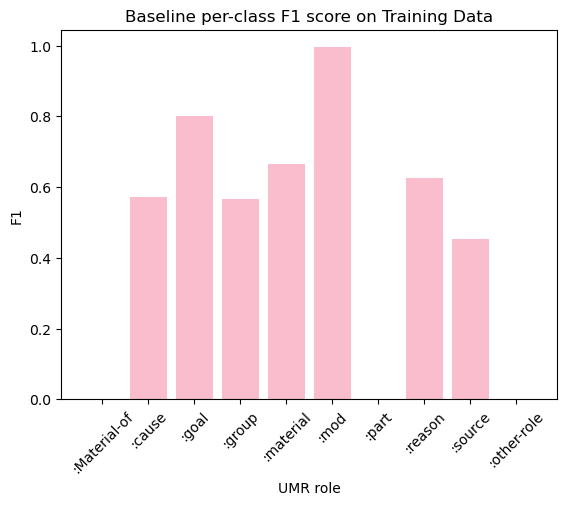

In [15]:
#plot trained data of baseline (rules only)
baseline_train_df = pd.read_csv("output/baseline_train.csv")
baseline_train_df['y_pred'] = baseline_train_df['y_pred'].apply(ast.literal_eval)

train_dict = get_per_class_f1(baseline_train_df)
print(train_dict)

x_values = list(train_dict.keys())
y_values = list(train_dict.values())
# Plot the data
plt.bar(x_values, y_values ,color =  '#FABDCD'  )# Purple

# Add labels and title
plt.xlabel('UMR role')
plt.ylabel('F1')
plt.title('Baseline per-class F1 score on Training Data')

plt.xticks( x_values, rotation = 45)

# Show the plot
plt.show()



## Dataset Information

In [16]:
#test data
test_data = pd.read_csv("input_data/test_data.csv")
train_data = pd.read_csv("input_data/train_data.csv")
print(test_data.columns)
file_counts = test_data["file"].value_counts()
value_counts = test_data["umr_role"].value_counts()
print(file_counts)
print(value_counts)

file_counts = train_data["file"].value_counts()
value_counts = train_data["umr_role"].value_counts()
print(file_counts)
print(value_counts)


# file_map = {1:"Lindsay",2: "Landslide", 3:"Putin",4:"Edmund Pope", 5:"Pear Story"}

Index(['Unnamed: 0', 'file', 'sent_i', 'sent', 'ne_info', 'amr_graph',
       'amr_head_name', 'amr_tail_name', 'amr_role', 'umr_head_name',
       'umr_tail_name', 'umr_role', 'amr_head_id', 'umr_head_id',
       'amr_tail_id', 'umr_tail_id'],
      dtype='object')
file
2    36
5    30
3    15
4     9
1     1
Name: count, dtype: int64
umr_role
:mod           46
:source         6
:reason         4
:ARG1           4
:extent         3
:other-role     3
:goal           2
:condition      1
:path           1
:material       1
:cause          1
:ARG0-of        1
:ARG1-of        1
:part           1
Name: count, dtype: int64
file
AMR to UMR targerted conversion split roles - Graphs.csv    50
Name: count, dtype: int64
umr_role
:mod            11
:source          5
:goal            4
:start           4
:reason          4
:cause           4
:material        4
:Cause-of        2
:group           2
:instrument      1
:Material-of     1
:undergoer       1
Name: count, dtype: int64


# Error Analysis
Using k-fold validation (k =5) we run the baseline, base_nn,  and combined nn, training on 4 and then testing on 1. We then examine the accuracies and confusion matricies. We look at the output layer weights of the combined nn to see how much we are rating the rules and how much we are rating the nn output

In [18]:
import error_analysis


directory_path = "output/k-foldv2/"
# List to store results
results = []

# Iterate through files in the directory
for file_name in os.listdir(directory_path):
    if file_name.endswith(".csv"):
        # Extract model and fold information from the file name
        model_fold = file_name.rsplit("_", 1)
        model = model_fold[0]
        fold = model_fold[1].split(".")[0]  # Remove the '.csv' extension
        fold = int(fold)

        # Read the CSV file into a DataFrame
        file_path = os.path.join(directory_path, file_name)
        df = pd.read_csv(file_path)

        # Calculate accuracy using your custom function
        f1 = get_macro_f1(df)

        # Append the results to the list
        results.append({'Model': model, 'Fold': fold, 'F1': f1})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)
print(results_df)

                         Model  Fold        F1
0                     baseline     0  0.651209
1                     baseline     1  0.687015
2                     baseline     2  0.697323
3                     baseline     3  0.573409
4                     baseline     4  0.620048
5                 base_nn_test     0  0.445935
6                 base_nn_test     1  0.488920
7                 base_nn_test     2  0.537737
8                 base_nn_test     3  0.474431
9                 base_nn_test     4  0.372835
10  nn_with_rules_weights_test     0  0.702751
11  nn_with_rules_weights_test     1  0.639897
12  nn_with_rules_weights_test     2  0.586560
13  nn_with_rules_weights_test     3  0.723122
14  nn_with_rules_weights_test     4  0.638752


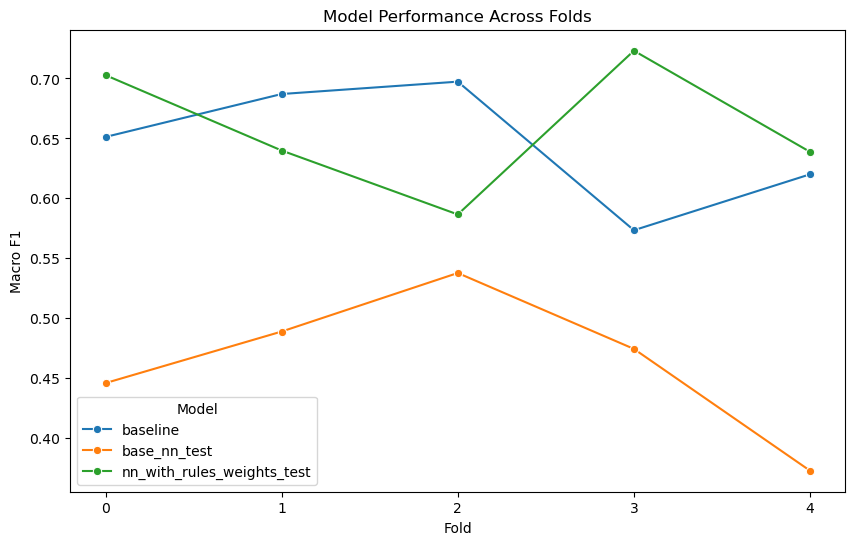

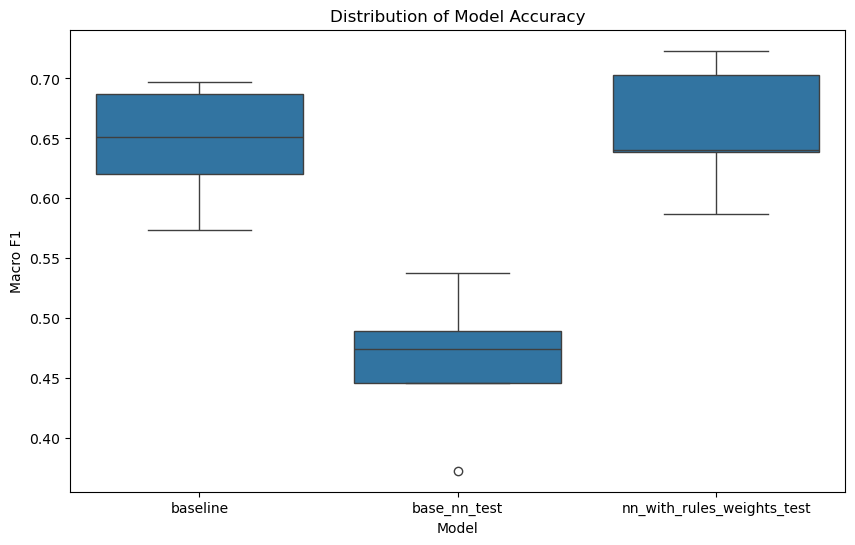

C:\Users\mcg19\AppData\Local\Temp\ipykernel_12836\3985509110.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, ci='sd')


ValueError: Could not interpret value `Accuracy` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Line Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Fold', y='F1', hue='Model', data=results_df, marker='o')
plt.title('Model Performance Across Folds')
plt.xlabel('Fold')
plt.xticks(range(0,5))
plt.ylabel('Macro F1')
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='F1', data=results_df)
plt.title('Distribution of Model Accuracy')
plt.ylabel('Macro F1')
plt.show()

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, ci='sd')
plt.title('Average Model Accuracy with Standard Deviation')
plt.ylabel('Average Accuracy')
sns.barplot(x='Model', y='F1', data=results_df, ci='sd')


## Confusion Matrices

In [20]:
import os
import pandas as pd

directory_path = "output/k-fold/"

# Create an empty dictionary to store dataframes for each model
model_dataframes = {}

# Iterate through files in the directory
for file_name in os.listdir(directory_path):
    if file_name.endswith(".csv"):
        model, fold = file_name.rsplit("_", 1)
        fold = int(fold.split(".")[0])

        # Read the CSV file into a DataFrame
        file_path = os.path.join(directory_path, file_name)
        df = pd.read_csv(file_path)

        # Add the dataframe to the dictionary based on the model name
        if model not in model_dataframes:
            model_dataframes[model] = []
        model_dataframes[model].append(df)

# Aggregate dataframes for each model across all folds
aggregated_dataframes = {}
for model, dfs in model_dataframes.items():
    aggregated_dataframes[model] = pd.concat(dfs, ignore_index=True)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter

def plot_normalized_heatmap(df, model_name):
    """
    Generate a normalized heatmap with counts for a specific model.

    Parameters:
    - df: Aggregated DataFrame containing 'true_labels' and model predictions for each fold.
    - model_name: Name of the model.

    Returns:
    - None (plots the normalized heatmap).
    """
    true_labels = df['umr_role']
    predictions = df['y_pred']

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    cm_df = pd.DataFrame(cm, index=np.unique(true_labels), columns=np.unique(true_labels))
    print(cm_df)

    # Normalize the confusion matrix
    cm_normalized = cm_df.div(cm_df.sum(axis=1), axis=0)
    cm_normalized[cm_normalized == 0] = np.nan

    # Get unique items and their counts
    unique_items, counts = np.unique(true_labels, return_counts=True)
    # Create a list of strings with item-count pairs
    y_ticks = [f"{item}({count})" for item, count in zip(unique_items, counts)]
    
    unique_items_P, counts_P = np.unique(predictions, return_counts= True  )


    # Use Counter to get counts of all items
    all_items_counts = Counter(predictions)

    # Get counts of items_to_get from all_items_counts
    result = [f"{item} ({all_items_counts.get(item, 0)})" for item in unique_items]
    
    x_ticks = result

    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=x_ticks, yticklabels=y_ticks,linewidths = 0.2, linecolor = "black")
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    
    plt.ylabel('True Label')
    plt.show()



In [23]:
model_name = 'nn_with_rules_weights_test'
aggregated_df = aggregated_dataframes[model_name]

plot_normalized_heatmap(aggregated_df, model_name)

KeyError: 'umr_role'

In [24]:
print(aggregated_dataframes["baseline"])

     Unnamed: 0                                               file  sent_i  \
0             2                                                  2       6   
1             7                                                  2      10   
2             8                                                  2      10   
3            13                                                  2      17   
4            16                                                  2      21   
..          ...                                                ...     ...   
100          22  AMR to UMR targerted conversion split roles - ...      26   
101          23  AMR to UMR targerted conversion split roles - ...      27   
102          28  AMR to UMR targerted conversion split roles - ...      32   
103          30  AMR to UMR targerted conversion split roles - ...      34   
104          36  AMR to UMR targerted conversion split roles - ...      38   

                                                  sent  \
0    

## Combined

This time we are going to take the max of each box and see who has the best performance. Then it will be color coded with the model.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter

def plot_differnetial_heatmap(df, model_name):
    """
    Generate a normalized heatmap with counts for a specific model.

    Parameters:
    - df: Aggregated DataFrame containing 'true_labels' and model predictions for each fold.
    - model_name: Name of the model.

    Returns:
    - None (plots the normalized heatmap).
    """
    true_labels = df['umr_role']
    predictions = df['y_pred']

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    cm_df = pd.DataFrame(cm, index=np.unique(true_labels), columns=np.unique(true_labels))
    print(cm_df)

    # Normalize the confusion matrix
    cm_normalized = cm_df.div(cm_df.sum(axis=1), axis=0)

    # Get unique items and their counts
    unique_items, counts = np.unique(true_labels, return_counts=True)
    # Create a list of strings with item-count pairs
    y_ticks = [f"{item}({count})" for item, count in zip(unique_items, counts)]
    
    unique_items_P, counts_P = np.unique(predictions, return_counts= True  )


    # Use Counter to get counts of all items
    all_items_counts = Counter(predictions)

    # Get counts of items_to_get from all_items_counts
    result = [f"{item} ({all_items_counts.get(item, 0)})" for item in unique_items]
    
    x_ticks = result

    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=x_ticks, yticklabels=y_ticks)
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    
    plt.ylabel('True Label')
    plt.show()



##Check animacy info as a parameter


In [ ]:
from animacyParser import  parse_animacy_runner

In [ ]:
def classify_on_animacy(df,model_name):
        named_entity = df["ne_info"]
        tails = df["amr_tail_name"]
        new_info = parse_animacy_runner(tails)
        print(type(new_info))
        print(new_info)
        animacy_info = []
        for ne_entry, tail in zip(named_entity, tails):
                item_anim = ""
                ne_entry = ast.literal_eval(ne_entry)
                if ne_entry:
                        for ne_dict in ne_entry:
                                for ne_type, ne_value in ne_dict.items():
                                        if ne_value == tail:
                                                item_anim = ne_type
                
                animacy_info.append(item_anim)
        print(len(animacy_info))
        df["animacy_info"] = animacy_info
        return df

model_name = 'nn_with_rules_weights_test'
new_df = classify_on_animacy(aggregated_dataframes[model_name], model_name)
                                
                

testing animacy on 105 sentences/words


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


COMBINED:  [[], [], [], [], [], [{'B_human': 'master'}], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [{'B_human': 'guy'}], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [{'B_human': 'child'}], [], [], [], [{'B_human': 'boy'}], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
<class 'list'>
[[], [], [], [], [], [{'B_human': 'master'}], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [{'B_human': 'guy'}], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [{'B_human': 'child'}], [], [], [], [{'B_human': 'boy'}], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []